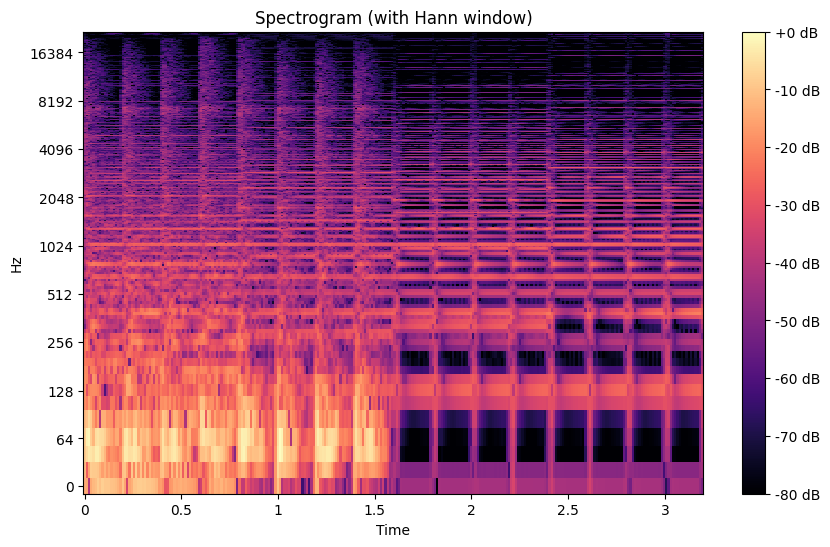

In [21]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Загружаем аудиофайл
audio_path = 'sample.wav'
y, sr = librosa.load(audio_path, sr=None)

# Построение спектрограммы с использованием окна Ханна
n_fft = 2048
hop_length = 512
window = 'hann'

# Вычисляем STFT
D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))

# Преобразование амплитуд в дБ
DB = librosa.amplitude_to_db(D, ref=np.max)

# Визуализация спектрограммы
plt.figure(figsize=(10, 6))
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (with Hann window)')
plt.savefig('spectrogram.png')
plt.show()


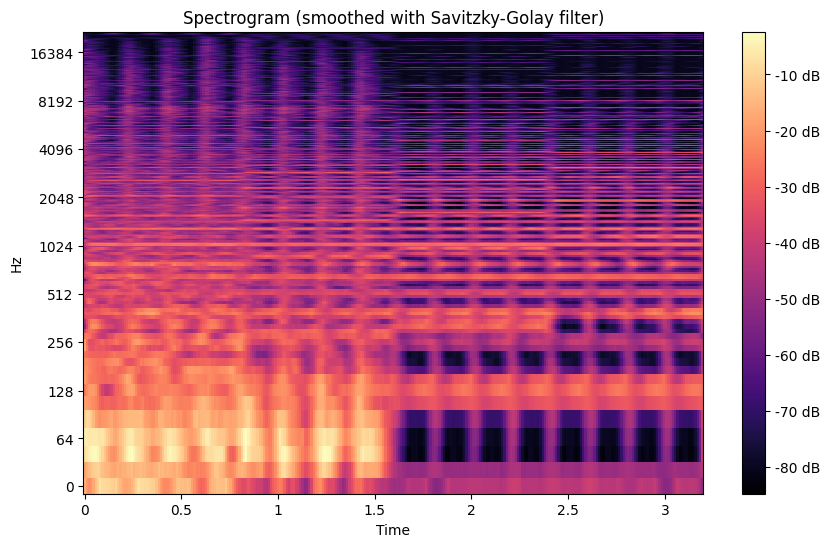

In [22]:
import numpy as np
from scipy.signal import savgol_filter
import librosa
import soundfile as sf

# Оценка уровня шума (примерно)
noise_estimation = np.mean(DB[:, :10], axis=1)  # Среднее значение первых 10 фреймов

# Фильтрация шума с использованием фильтра Савицкого-Голея
smoothed_DB = savgol_filter(DB, 11, 3, axis=1)  # окно 11 и полином 3-й степени

# Восстановление звуковой дорожки
D_smoothed = librosa.db_to_amplitude(smoothed_DB, ref=np.max(DB))
y_smoothed = librosa.istft(D_smoothed, hop_length=hop_length)

# Сохранение восстановленного аудио
sf.write('smoothed_audio.wav', y_smoothed, sr)

# Визуализация спектрограммы после фильтрации
plt.figure(figsize=(10, 6))
librosa.display.specshow(smoothed_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (smoothed with Savitzky-Golay filter)')
plt.savefig('spectrogram_smoothed.png')
plt.show()


Times with highest energy: [0.02321995 0.09287982 0.26702948 0.29024943 0.40634921 0.46439909
 0.6153288  0.67337868 0.82430839 0.83591837 1.01006803 1.021678
 1.19582766 1.20743764 1.30031746 1.40480726 1.4860771  1.59056689
 1.72988662 1.79954649 1.91564626 2.00852608 2.11301587 2.19428571
 2.31038549 2.40326531 2.41487528 2.58902494 2.6122449  2.77478458
 2.80961451 2.96054422 2.98376417 3.14630385 3.16952381]


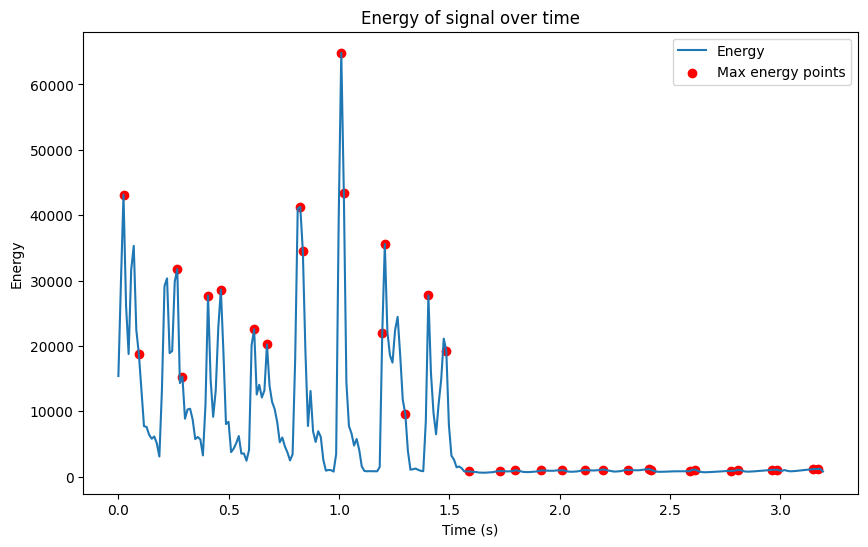

In [23]:
# Энергия сигнала
energy = np.sum(D**2, axis=0)

# Поиск моментов с наибольшей энергией в окрестности Δt = 0,1 c
step = int(0.1 * sr / hop_length)
max_energy_indices = []

for i in range(0, len(energy), step):
    segment = energy[i:i + step]
    max_index = i + np.argmax(segment)
    max_energy_indices.append(max_index)

# Печать результатов
times = librosa.frames_to_time(max_energy_indices, sr=sr, hop_length=hop_length)
print("Times with highest energy:", times)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(librosa.frames_to_time(range(len(energy)), sr=sr, hop_length=hop_length), energy, label='Energy')
plt.scatter(librosa.frames_to_time(max_energy_indices, sr=sr, hop_length=hop_length), energy[max_energy_indices], color='red', label='Max energy points')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Energy of signal over time')
plt.legend()
plt.savefig('energy_peaks.png')
plt.show()
